# Final Project - Predicting Probabilties of NCAA Men's Basketball Tournament Outcomes 
## Group 2 - 90-803 Machine Learning Foundations with Python (Spring 2023)
### Authors: Samira Diabi, Amelia Janaskie, Genna Moellering

**Question:** Have tournament outcomes become harder to predict in the Name Image & Likeness (NIL) Era where NCAA athletes can be paid by universities?  We compare probability gaps in game outcomes from previous tournaments to see if prediction windows are becoming tighter and, consequently, game outcomes more uncertain.  (Prediction with a Target Variable of win probability for a given team - TeamA)


**Models Used:**
* Logistic Regression
* Random Forrest
* Naive Bayes
* Support Vector Machine Classifier

In [80]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler

# Modeling Libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Visualization Libraries
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
from pandas.plotting import parallel_coordinates


In [2]:
seed = 12

### Methodology
The aim of this question is to see what our classification models, which we refined in Question 1, can tell us about whether it's getting harder to predict the outcome of tournament games. To analyze this question, we will look to see whether the predictions are getting tighter. An example of a 'tighter' prediction would be a .55 favorability rating that a given team (in this case TeamA) will win, which is barely better than a coin flip. A more conventional probability rating for a betting-line favorite would be a rating of .7. The 'tightness' of the probability prediction will give us some measure of whether or not game outcomes are getting more difficult to predict. 

Our methodology for approaching this question is to use the classification models from question 1 to generate a probability predicting whether TeamA will win for all the NCAA tournament games in a given season. We will take the absolute distance of that value from .5 (which represents a 50/50 chance) and then sum those values across the games played in the tournmanet. We will conduct this process for each of our four models and each of the five years of interest: 2018, 2019, 2021, 2022, and 2023. (There was no NCAA Men's Basketball Tournament held in 2020 due to the COVID-19 pandemic). 

For our first step, we read in the original `final_df`

In [3]:
df = pd.read_csv('data/final_df.csv')
df.head()

,Season,DayNum,TeamA,TeamB,Win,A_PPG,A_FG%,A_FG3%,A_FT%,A_OR_per_game,...,B_Blk_per_game,B_PF_per_game,B_Road_Wins,B_ConfAbbrev,B_TeamName,B_TotalD1Seasons,B_Seed,B_CoachName,B_Qualified,TourneyGame
0,2003,10,1328,1104,0,71,45,39,71,12,...,4,18,4,28,Alabama,39,54,578,1,0
1,2003,10,1393,1272,0,80,47,33,69,14,...,5,19,9,12,Memphis,39,72,462,1,0
2,2003,11,1437,1266,0,72,42,35,71,15,...,4,19,8,12,Marquette,39,47,901,1,0
3,2003,11,1457,1296,0,69,43,35,64,12,...,4,20,10,18,N Illinois,39,0,765,0,0
4,2003,11,1458,1186,1,71,46,36,74,10,...,3,21,9,6,E Washington,39,0,735,0,0


### Breaking Out the Datasets

This question pertains primarily to tournament data, as we are trying to compare our models' tournament outcomes predictions in specific years. We created dataframes for just the tournamnet game in each year, and in those dataframes, dropped the ones that weren't offering additional information. Everyone playing in the tournament qualified, which is why I'm dropping these columns.

In [4]:
# tourney will only reflect the tournament games
tourney = df[df['TourneyGame']==1]

# only the tournament games for the specific year
tourney_2018 = tourney[tourney['Season'] == 2018]
tourney_2019 = tourney[tourney['Season'] == 2019]
tourney_2021 = tourney[tourney['Season'] == 2021]
tourney_2022 = tourney[tourney['Season'] == 2022]
tourney_2023 = tourney[tourney['Season'] == 2023]

# dropping irrelevant or string-type columns
tourney_df = tourney.drop(['A_Qualified', 'B_Qualified', 'TourneyGame', 'A_TeamName', 'B_TeamName', 'DayNum', 'TeamA', 'TeamB'], axis=1)

# print sample as a check on accuracy
tourney_df.head()

,Season,Win,A_PPG,A_FG%,A_FG3%,A_FT%,A_OR_per_game,A_DR_per_game,A_Ast_per_game,A_TO_per_game,...,B_Ast_per_game,B_TO_per_game,B_Stl_per_game,B_Blk_per_game,B_PF_per_game,B_Road_Wins,B_ConfAbbrev,B_TotalD1Seasons,B_Seed,B_CoachName
4616,2003,1,71,43,36,76,12,23,13,16,...,14,15,6,2,18,7,33,39,43,795
4617,2003,0,68,44,34,66,13,26,14,14,...,18,15,8,4,18,11,25,39,66,571
4618,2003,0,75,44,35,65,14,26,17,14,...,16,14,5,4,19,6,25,39,75,762
4619,2003,0,79,50,39,69,11,23,17,13,...,16,18,7,4,21,12,18,39,76,384
4620,2003,0,72,46,35,77,10,22,15,14,...,16,14,7,3,17,8,25,39,8,40


We will need `df` in its original form to generate the X_train, y_train, X_test, y_test datasets, but we don't want to include the qualified or teamname columns as they are either irrelevant or string data and we don't want the models to take them as inputs. 

In [5]:
df = df.drop(['A_Qualified', 'B_Qualified', 'A_TeamName', 'B_TeamName'], axis=1)

Our seasons of interest are 2018, 2019, 2021, 2022, and 2023, so I generated seperate datasets for these seasons. A reminder that there was no tournament in 2020 due to the COVID-19 pandemic, so we are excluding that year because there is no data available.

In [6]:
# predict 2018 outcomes
results_2018 = tourney_df[tourney_df['Season'] == 2018]
results_2018 = results_2018.drop(['Season'], axis=1)

# predict 2019 outcomes
results_2019 = tourney_df[tourney_df['Season'] == 2019]
results_2019 = results_2019.drop(['Season'], axis=1)

# predict 2021 outcomes
results_2021 = tourney_df[tourney_df['Season'] == 2021]
results_2021 = results_2021.drop(['Season'], axis=1)

# predict 2022 outcomes
results_2022 = tourney_df[tourney_df['Season'] == 2022]
results_2022 = results_2022.drop(['Season'], axis=1)



We had to use the dataset we generated to get data from the 2023 tournament, so we read that in that here.

In [7]:
# reading in the 2023 tournament results and the annual info from the data cleaning files to append 
tourney_2023_results = pd.read_csv('data/2023_Tourney_Outcomes.csv')
annual_info_A = pd.read_csv('data/annual_info_A.csv')
annual_info_B = pd.read_csv('data/annual_info_B.csv')

tourney_2023_admin = tourney_2023_results[['Season','TeamA','TeamB','Win','A_TeamName','B_TeamName']]

tourney_2023_short = tourney_2023_results[['Season','TeamA','TeamB','Win']]


The `tournament_2023 reults` dataframe did not get the benefit of our data cleaning process, so here I am merging it with the administrative data we generated in the **Data_Cleaning** notbeook so that it looks uniform to the rest of our data. 

In [8]:
# Merge with annual information for Team A
results_2023 = tourney_2023_short.merge(annual_info_A, how='inner', on=['Season','TeamA'])

# Merge with annual information for Team B
results_2023 = results_2023.merge(annual_info_B, how='inner', on=['Season','TeamB'])

results_2023 = results_2023.drop(['Season', 'TeamA', 'TeamB', 'A_TeamName', 'B_TeamName', 'A_Qualified', 'B_Qualified'], axis=1)

# As we can see, A_Seed and B_seed are the columns that contain NaN values. We will replace the NaN with 'Unknown'
results_2023['A_Seed'].fillna(value='Unknown', inplace=True)
results_2023['B_Seed'].fillna(value='Unknown', inplace=True)

# Creating a list of column names to encode
cols_to_encode = ['A_ConfAbbrev','A_Seed','A_CoachName','B_ConfAbbrev','B_Seed','B_CoachName']

# Instantiating the LabelEncoder object
le = LabelEncoder()

# Looping through the columns to encode and apply label encoding
for col in cols_to_encode:
    results_2023[col] = le.fit_transform(results_2023[col])

# Printing out first five rows to check
results_2023.head()

,Win,A_PPG,A_FG%,A_FG3%,A_FT%,A_OR_per_game,A_DR_per_game,A_Ast_per_game,A_TO_per_game,A_Stl_per_game,...,B_Ast_per_game,B_TO_per_game,B_Stl_per_game,B_Blk_per_game,B_PF_per_game,B_Road_Wins,B_ConfAbbrev,B_TotalD1Seasons,B_Seed,B_CoachName
0,1,78,45,37,80,10,23,15,12,8,...,13,12,7,3,21,10,12,32,16,3
1,0,78,45,37,80,10,23,15,12,8,...,15,14,6,5,19,14,15,39,8,28
2,1,71,44,34,74,9,23,13,11,7,...,15,14,6,5,19,14,15,39,8,28
3,0,70,45,33,74,9,23,12,10,5,...,15,14,6,5,19,14,15,39,8,28
4,1,76,45,36,76,9,24,14,11,5,...,14,12,9,3,15,9,15,39,24,7


Before splitting our test and train data, we want to remove the season data for the years we'd like to predict later on.  We remove those years of interest here.

In [9]:
# Pull out the tournament games for 2018-2023 and leave the rest (we don't want to train the model on data it will see later)
condition = ((df["Season"].isin([2018, 2019, 2021, 2022])) & (df["TourneyGame"] == 1))

df = df[~condition]

df = df.drop(['Season', 'DayNum', 'TeamA', 'TeamB', 'TourneyGame'], axis=1)

Here we generate our X_train, X_test, y_train, y_test using Win as our target. We have a lot of data, so we use a test size of .25

In [10]:
X = df[df.columns.difference(['Win'])]
y = df['Win']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

Now it's time to scale our data and fit the scaling object to our train and test data.

We broke out individual X and y sets for each year of interest as well so we can run our models on individual years after having trained on the larger dataset that spans data from 2003 - 2017.

In [11]:
# Initializing the scaler object
scaler = PowerTransformer()

# Fitting the scaler object on the X_train and X_test
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Generating separate X,y for each year of interest, 2018-2023
X_2018 = results_2018[results_2018.columns.difference(['Win'])]
y_2018 = results_2018['Win']

X_2019 = results_2018[results_2019.columns.difference(['Win'])]
y_2019 = results_2019['Win']

X_2021 = results_2021[results_2021.columns.difference(['Win'])]
y_2021 = results_2021['Win']

X_2022 = results_2022[results_2022.columns.difference(['Win'])]
y_2022 = results_2022['Win']

X_2023 = results_2022[results_2022.columns.difference(['Win'])]
y_2023 = results_2022['Win']

# Transforming the data
results_2018_scaled = scaler.fit_transform(results_2018)
results_2019_scaled = scaler.fit_transform(results_2019)
results_2021_scaled = scaler.fit_transform(results_2021)
results_2022_scaled = scaler.fit_transform(results_2022)
results_2023_scaled = scaler.fit_transform(results_2023)


Our TeamA TeamB selection was essentially random, but here we do a quick balance check to make sure that our wins are not skewed. They are very close so no additional balancing is needed.

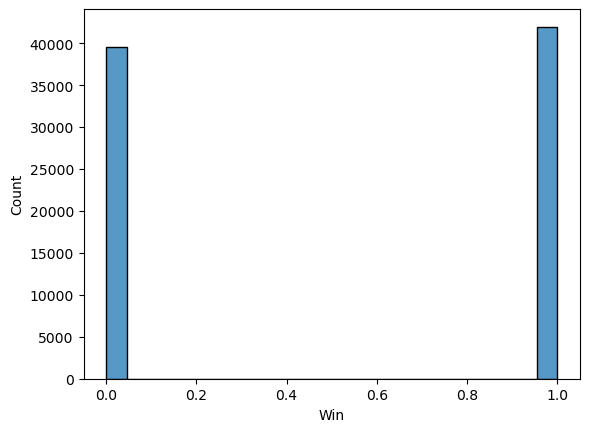

In [12]:
sns.histplot(data=y_train);

### Logistic Regression

Our first model is a logisitic regression - here we initialize the model with our random_seed and set a max_iter of 20,000, which was set after we got convergence warnings for a max_iter of 10,000.

In [13]:
# initialize and fit the model
lr = LogisticRegression(random_state=seed, max_iter=20000)
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

# print the accuracy score
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.730757899388672


The model has a pretty high accuracy score of 73.1%!  Very exciting stuff...

Now we will use GridSearchCV to tune our hyperparameters and see if we can make it even better.  

In [14]:
# avoiding the warnings that come with GridSearchCV
import warnings
warnings.filterwarnings('ignore')

# parameter grid
parameters = {
    'penalty' : ['l1','l2','elasticnet',None], 
    'C'       : [.1,1,10],
    'solver'  : ['newton-cg', 'sag', 'liblinear'],
}

# run a GridSearchCV function to find the optimal parameters
clf = GridSearchCV(lr,                        # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10)                     # number of folds

# train using the training set
clf.fit(X_train,y_train)

# print out the tuned hyperparameters and training accuracy
print("Tuned Hyperparameters :", clf.best_params_)
print("Accuracy :",clf.best_score_)

Tuned Hyperparameters : {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy : 0.7230453771270364


Now that we have our tuned hyperparameters, we'll re-initialize the model with those recommended settings and train the model again.

In [15]:
# re-initializing the model with tuned parameters
lr = LogisticRegression(random_state=seed, max_iter=20000,
                            C = 0.1, 
                            penalty = 'l1', 
                            solver = 'liblinear')

# training model
lr.fit(X_train,y_train)
y_pred_lr_tuned = lr.predict(X_test)

# print accuracy using score
print("Accuracy:",lr.score(X_test, y_test))

Accuracy: 0.730757899388672


It doesn't look like our tuning helped improve our accuracy that much. What a bummer...

Next, we'll generate a confusion matrix to see if the model has a hard time predicting a particular class.

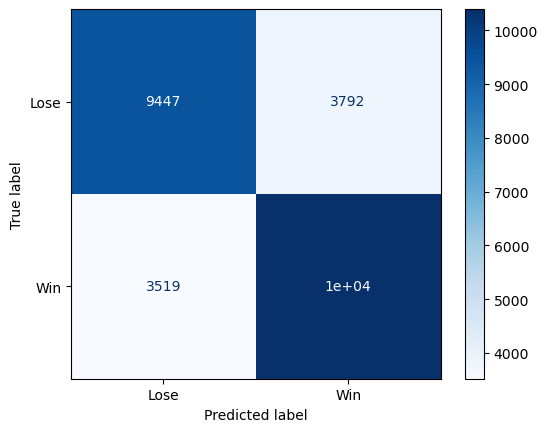

In [16]:
# Calculating the confusion matrix for the LR tuned
cm_lr_tuned = confusion_matrix(y_test, y_pred_lr_tuned)

# Creating a ConfusionMatrixDisplay object 
display_cm_lr_tuned = ConfusionMatrixDisplay(confusion_matrix=cm_lr_tuned, display_labels=['Lose', 'Win'])

# Plotting the confusion matrix using ConfusionMatrixDisplay object
display_cm_lr_tuned.plot(cmap='Blues')

In [17]:
# generate the classification report
print(classification_report(y_test, y_pred_lr_tuned, digits= 2, target_names=['Lose', 'Win']))

              precision    recall  f1-score   support

        Lose       0.73      0.71      0.72     13239
         Win       0.73      0.75      0.74     13915

    accuracy                           0.73     27154
   macro avg       0.73      0.73      0.73     27154
weighted avg       0.73      0.73      0.73     27154



Our accuracy is right around 73%, but interestingly, it looks like TeamA wins and loses about an equal number of times. Looking at the true labels, the difference between TeamA wins and losses was only 676 games, which favored wins. The logistic regression did a little better predicting wins than losses.

Now it's time to apply our trained model just to the tournament games in our years of interest. In the following section, we predict the outcomes for each tournamnet, check our accuracy score, and return the yearly accuracy ratings in a condensed dataframe called `lr_accuracy`

In [18]:
# predicting outcomes for each tournament year
lr_pred_2018 = lr.predict(X_2018)
lr_pred_2019 = lr.predict(X_2019)
lr_pred_2021 = lr.predict(X_2021)
lr_pred_2022 = lr.predict(X_2022)
lr_pred_2023 = lr.predict(X_2023)

# gathering accuracy scores for each tournament year
lr_accuracy_2018 = accuracy_score(y_2018, lr_pred_2018)
lr_accuracy_2019 = accuracy_score(y_2019, lr_pred_2019)
lr_accuracy_2021 = accuracy_score(y_2021, lr_pred_2021)
lr_accuracy_2022 = accuracy_score(y_2022, lr_pred_2022)
lr_accuracy_2023 = accuracy_score(y_2023, lr_pred_2023)

# condensing accuracy ratings into a dataframe
years=['2018','2019','2021','2022','2023']
lr_accuracy = pd.DataFrame([[lr_accuracy_2018,lr_accuracy_2019,lr_accuracy_2021,lr_accuracy_2022,lr_accuracy_2023]], columns=years)
lr_accuracy.index = ['lr_accuracy']

# print dataframe to check accuracy
lr_accuracy


,2018,2019,2021,2022,2023
lr_accuracy,0.522388,0.492537,0.5,0.492537,0.492537


We can see from the output above that the accuarcy ratings listed here are much worse than the accuracy we got for our test data covering all years from 2003-2017. In a way, it makes sense that the accuracy ratings would drop with few games to predict in a given tournamnet year, and the bracket structure heavily penalizes any errors made in the beginning of the tournament.

Later on, when we interpret our tournament outcomes, we'll want to be able to see what team matchups were associated with the predictions we made. The code below adds the binary classifier and the probability prediction onto the dataframe with all the team and game information for interpretability. 

In [19]:
# add the classification predictions and probability predictions to all the original tournamnet game information for 2018 (for interpretability)
lr_pred_prob_2018 = lr.predict_proba(X_2018)
lr_pred_prob_2018 = np.float64(lr_pred_prob_2018)

# takes the predictions out of scientific notation 
pd.set_option('display.float_format', lambda x: '%.5f' % x)
tourney_2018['Win_Pred'] = lr_pred_2018
tourney_2018['Win_Prob'] = lr_pred_prob_2018[:,1]
tourney_2018 = tourney_2018.drop(['DayNum','TourneyGame','A_Qualified', 'B_Qualified'], axis=1)

# add the classification predictions and probability predictions to all the original tournamnet game information for 2019
lr_pred_prob_2019 = lr.predict_proba(X_2019)
lr_pred_prob_2019 = np.float64(lr_pred_prob_2019)
tourney_2019['Win_Pred'] = lr_pred_2019
tourney_2019['Win_Prob'] = lr_pred_prob_2019[:,1]
tourney_2019 = tourney_2019.drop(['DayNum','TourneyGame','A_Qualified', 'B_Qualified'], axis=1)

# add the classification predictions and probability predictions to all the original tournamnet game information for 2021
lr_pred_prob_2021 = lr.predict_proba(X_2021)
lr_pred_prob_2021 = np.float64(lr_pred_prob_2021)
tourney_2021['Win_Pred'] = lr_pred_2021
tourney_2021['Win_Prob'] = lr_pred_prob_2021[:,1]
tourney_2021 = tourney_2021.drop(['DayNum','TourneyGame','A_Qualified', 'B_Qualified'], axis=1)

# add the classification predictions and probability predictions to all the original tournamnet game information for 2022
lr_pred_prob_2022 = lr.predict_proba(X_2022)
lr_pred_prob_2022 = np.float64(lr_pred_prob_2022)
tourney_2022['Win_Pred'] = lr_pred_2022
tourney_2022['Win_Prob'] = lr_pred_prob_2022[:,1]
tourney_2022 = tourney_2022.drop(['DayNum','TourneyGame','A_Qualified', 'B_Qualified'], axis=1)

# add the classification predictions and probability predictions to all the original tournamnet game information for 2023
lr_pred_prob_2023 = lr.predict_proba(X_2023)
lr_pred_prob_2023 = np.float64(lr_pred_prob_2023)
results_2023['Win_Pred'] = lr_pred_2023
results_2023['Win_Prob'] = lr_pred_prob_2023[:,1]
tourney_2023 = pd.concat([tourney_2023_admin, results_2023], axis=1)
tourney_2023 = tourney_2023.T.groupby(level=0).first().T

# print the head of one of the dataframes here, just to check and make sure it looks good
tourney_2023.head()


,A_Ast_per_game,A_Blk_per_game,A_CoachName,A_ConfAbbrev,A_DR_per_game,A_FG%,A_FG3%,A_FT%,A_OR_per_game,A_PF_per_game,...,B_Stl_per_game,B_TO_per_game,B_TeamName,B_TotalD1Seasons,Season,TeamA,TeamB,Win,Win_Pred,Win_Prob
0,15,2,43,18,23,45,37,80,10,19,...,7,12,SE Missouri St,32,2023,1394,1369,1,0,0.00771
1,15,2,43,18,23,45,37,80,10,19,...,6,14,Mississippi St,39,2023,1338,1280,1,0,0.43687
2,13,4,6,15,23,44,34,74,9,16,...,6,14,F Dickinson,39,2023,1411,1192,0,0,0.00000
3,12,4,28,7,23,45,33,74,9,16,...,6,14,Arizona St,39,2023,1305,1113,0,0,0.00096
4,14,4,19,2,24,45,36,76,9,16,...,9,12,Alabama,39,2023,1394,1104,0,0,0.00000


Apart from accuracy, we want to be able to do a side-by-side comparieson of how 'confident' the predicted probabilities are. This will help us answer our fundamental question concerning whether or not tournament outcomes are getting more difficult to predict. 

In the following code, we take the probability predictions for each game in each year and concatenate them into a new dataframe called `lr_results`

In [20]:
# concatenate the predicted probability dataframes previously generated so that each year is represented
lr_results = pd.concat([pd.DataFrame(lr_pred_prob_2018[:,1]), pd.DataFrame(lr_pred_prob_2019[:,1]), 
                        pd.DataFrame(lr_pred_prob_2021[:,1]), pd.DataFrame(lr_pred_prob_2022[:,1]), 
                        pd.DataFrame(lr_pred_prob_2023[:,1])], axis=1)

# create headings corresponding to each year
lr_results = lr_results.set_axis(['2018', '2019', '2021', '2022', '2023'], axis=1, inplace=False)

# print results to check for accuracy
lr_results

,2018,2019,2021,2022,2023
0,0.00039,0.00039,0.00007,0.00771,0.00771
1,0.00000,0.00000,0.00000,0.43687,0.43687
2,0.00435,0.00435,0.00001,0.00000,0.00000
3,0.00042,0.00042,0.00051,0.00096,0.00096
4,0.00000,0.00000,0.00485,0.00000,0.00000
...,...,...,...,...,...
62,0.86672,0.86672,0.00000,0.00159,0.00159
63,0.03278,0.03278,0.00000,0.00000,0.00000
64,0.00002,0.00002,0.00351,0.05857,0.05857
65,0.24405,0.24405,0.00000,0.00020,0.00020


In order to accurately measure the condfidence of our models' predictions, we need to make sure we are equally weighting the numbers very close to 1 (very certain that TeamA will win) and the numbers very close to 0 (very certain that TeamA will not win). This process should also apply for the unconfident predictions that are barley favoring one team or the other. To do that, we applied a function taht takes the absolute value of each predictions distance from .5, which represents no prediction at all. This gives us our 'confidence' metric, which we can use to see if game predictions are getting less certain. Aggregate predictions across years that are smaller indiciate more uncertaintly.

In [21]:
# apply lambda function to normalize confidence predictions around 0.5
lr_results = lr_results.apply(lambda x: abs(x-.5))
lr_confidence = lr_results.sum().to_frame().T
lr_confidence.index = ['lr_confidence']

# create a matrix that takes the confidence and accuracy dataframes created previously to make one matrix holding the results for logistic regression
lr_matrix = pd.concat([lr_confidence,lr_accuracy],axis=0)
lr_matrix

,2018,2019,2021,2022,2023
lr_confidence,29.15519,29.15519,29.11121,28.24326,28.24326
lr_accuracy,0.52239,0.49254,0.50000,0.49254,0.49254


### Naive Bayes

Our second model is a Gaussian Naive Bayes - here we start by initializing the model.

In [22]:
gnb = GaussianNB()
gnb.fit(X_train,y_train)
y_pred = gnb.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7191205715548353


The initial accuracy score is slightly worse than what we found with the logistic regression, but in our next step we will tune the hyperparameters to see if we can improve on that.

In [23]:
# parameter grid - commented out to reduce commpute time
# parameters = {
#     'var_smoothing': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15]
# }

# # run a GridSearchCV function to find the optimal parameters
# gnb_clf = GridSearchCV(gnb,                         # model
#                        param_grid = parameters,    # hyperparameters
#                        scoring='accuracy',          # metric for scoring
#                        cv=10)                       # number of folds

# # train using the training set
# gnb_clf.fit(X_train, y_train)

# # print out the tuned hyperparameters and training accuracy
# print("Tuned Hyperparameters :", gnb_clf.best_params_)
# print("Accuracy :",gnb_clf.best_score_)

# output from the above code
# Tuned Hyperparameters : {'var_smoothing': 0.0001}
# Accuracy : 0.703931950326813


Our ideal var_smoothing outcome was .0001, so we apply that to our model and use it to generate our predictions on the test data - similar to the logistic regression model, the tuned hyperparameters don't seem to make an impact on accuracy.

In [24]:
gnb = GaussianNB(var_smoothing=0.0001)
gnb.fit(X_train,y_train)
y_pred_gnb_tuned = gnb.predict(X_test)
print("Accuracy:",gnb.score(X_test, y_test))

Accuracy: 0.7191205715548353


Next, we'll generate a confusion matrix to see if the model has a hard time predicting a particular class.

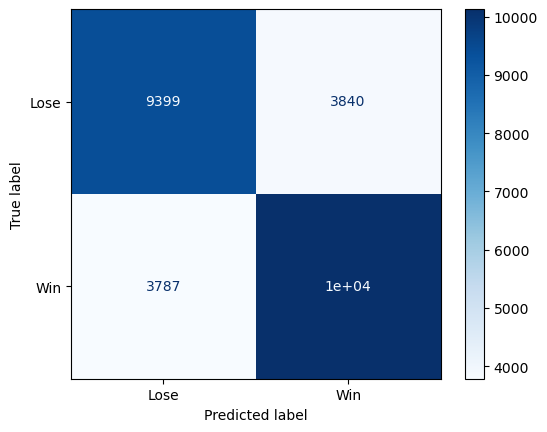

In [25]:
# Calculating the confusion matrix for the GNB tuned
cm_gnb_tuned = confusion_matrix(y_test, y_pred_gnb_tuned)

# Creating a ConfusionMatrixDisplay object 
display_cm_gnb_tuned = ConfusionMatrixDisplay(confusion_matrix=cm_gnb_tuned, display_labels=['Lose', 'Win'])

# Plotting the confusion matrix using ConfusionMatrixDisplay object
display_cm_gnb_tuned.plot(cmap='Blues')

In [26]:
print(classification_report(y_test, y_pred_gnb_tuned, digits= 2, target_names=['Lose', 'Win']))

              precision    recall  f1-score   support

        Lose       0.71      0.71      0.71     13239
         Win       0.73      0.73      0.73     13915

    accuracy                           0.72     27154
   macro avg       0.72      0.72      0.72     27154
weighted avg       0.72      0.72      0.72     27154



Our accuracy is right around 72%, which is slighly worse than our logistic regression model. Similar to the logistic regression the Gaussian Naive Bayes did a little better predicting wins than losses.

Now it's time to apply our trained model just to the tournament games in our years of interest. In the following section, we predict the outcomes for each tournamnet, check our accuracy score, and return the yearly accuracy ratings in a condensed dataframe called `gnb_accuracy`

In [27]:
# predicting outcomes for each tournament year
gnb_pred_2018 = gnb.predict(X_2018)
gnb_pred_2019 = gnb.predict(X_2019)
gnb_pred_2021 = gnb.predict(X_2021)
gnb_pred_2022 = gnb.predict(X_2022)
gnb_pred_2023 = gnb.predict(X_2023)

# gathering accuracy scores for each tournament year
gnb_accuracy_2018 = accuracy_score(y_2018, gnb_pred_2018)
gnb_accuracy_2019 = accuracy_score(y_2019, gnb_pred_2019)
gnb_accuracy_2021 = accuracy_score(y_2021, gnb_pred_2021)
gnb_accuracy_2022 = accuracy_score(y_2022, gnb_pred_2022)
gnb_accuracy_2023 = accuracy_score(y_2023, gnb_pred_2023)

# condensing accuracy ratings into a dataframe
years=['2018','2019','2021','2022','2023']
gnb_accuracy = pd.DataFrame([[gnb_accuracy_2018,gnb_accuracy_2019,gnb_accuracy_2021,gnb_accuracy_2022,gnb_accuracy_2023]], columns=years)
gnb_accuracy.index = ['gnb_accuracy']

# print dataframe to check accuracy
gnb_accuracy

,2018,2019,2021,2022,2023
gnb_accuracy,0.46269,0.49254,0.53030,0.46269,0.46269


The accuracy for this model is a little worse across the 5 years of interest, although, interestingly, it outperforms the logisitc regression for 2021. 

Again, we generate the binary clssifier and probability prediction columns that we can add onto our original dataframe for interpretability later on if needed. 

In [28]:
# format the probability predictions so they can be applied to all the original tournamnet game information for each year (for interpretability)
gnb_pred_prob_2018 = gnb.predict_proba(X_2018)
gnb_pred_prob_2018 = np.float64(gnb_pred_prob_2018)
gnb_pred_prob_2019 = gnb.predict_proba(X_2019)
gnb_pred_prob_2019 = np.float64(gnb_pred_prob_2019)
gnb_pred_prob_2021 = gnb.predict_proba(X_2021)
gnb_pred_prob_2021 = np.float64(gnb_pred_prob_2021)
gnb_pred_prob_2022 = gnb.predict_proba(X_2022)
gnb_pred_prob_2022 = np.float64(gnb_pred_prob_2022)
gnb_pred_prob_2023 = gnb.predict_proba(X_2023)
gnb_pred_prob_2023 = np.float64(gnb_pred_prob_2023)

Following the same process as we did for the logistic regression, we use the following code to get the predicted probabilities for each year using the GNB model and will use that along with our accuracy data to generate our final `gnb_matrix`.

In [29]:
# concatenate the predicted probability dataframes previously generated so that each year is represented
gnb_results = pd.concat([pd.DataFrame(gnb_pred_prob_2018[:,1]), pd.DataFrame(gnb_pred_prob_2019[:,1]), 
                        pd.DataFrame(gnb_pred_prob_2021[:,1]), pd.DataFrame(gnb_pred_prob_2022[:,1]), 
                        pd.DataFrame(gnb_pred_prob_2023[:,1])], axis=1)

# create headings corresponding to each year
gnb_results = gnb_results.set_axis(['2018', '2019', '2021', '2022', '2023'], axis=1, inplace=False)

# print results to check for accuracy
gnb_results

,2018,2019,2021,2022,2023
0,1.00000,1.00000,0.00000,0.00000,0.00000
1,0.00000,0.00000,1.00000,0.00000,0.00000
2,1.00000,1.00000,1.00000,0.00000,0.00000
3,0.00000,0.00000,0.00000,1.00000,1.00000
4,0.00000,0.00000,1.00000,0.00000,0.00000
...,...,...,...,...,...
62,0.00000,0.00000,0.00000,1.00000,1.00000
63,1.00000,1.00000,0.00000,1.00000,1.00000
64,1.00000,1.00000,0.00000,1.00000,1.00000
65,0.00000,0.00000,0.00000,0.00000,0.00000


In [30]:
# apply lambda function to normalize confidence predictions around 0.5
gnb_results = gnb_results.apply(lambda x: abs(x-.5))
gnb_confidence = gnb_results.sum().to_frame().T
gnb_confidence.index = ['gnb_confidence']

# create a matrix that takes the confidence and accuracy dataframes created previously to make one matrix holding the results for gassian naive bayes
gnb_matrix = pd.concat([gnb_confidence,gnb_accuracy],axis=0)
gnb_matrix

,2018,2019,2021,2022,2023
gnb_confidence,33.50000,33.50000,33.00000,33.50000,33.50000
gnb_accuracy,0.46269,0.49254,0.53030,0.46269,0.46269


### Random Forest Classifier

Our third model is a Random Forest Classifier - here we start by initializing the model.

In [38]:
rf = RandomForestClassifier(random_state=seed)
rf.fit(X_train, y_train)

print("------ TRAIN ----------")
print(rf.score(X_train, y_train))
print("------ TEST ----------")
print(rf.score(X_test, y_test))

------ TRAIN ----------
0.9123629712377702
------ TEST ----------
0.6780216542682478


The random forest classifier does really well on our training dataset (91.2%), but it looks like its overfitting as it doesn't generalize well to our unseen test data (only 67.8%).

Next, we'll generate a classification report to see if the model has a hard time predicting a particular class.

In [32]:
print(classification_report(y_test, rf.predict(X_test),target_names=["Lose","Win"]))

              precision    recall  f1-score   support

        Lose       0.67      0.66      0.67     13239
         Win       0.68      0.70      0.69     13915

    accuracy                           0.68     27154
   macro avg       0.68      0.68      0.68     27154
weighted avg       0.68      0.68      0.68     27154



It looks like, initially, the random forest is doing similarly to our other models in that it has a harder time accurately predicting loses rather than wins.  Our next step will be to tune the hyperparameters to see if we can improve on our initial results.

In [35]:
# commented out to reduce compute time for code
# rf = RandomForestClassifier(random_state=seed)
parameters = {'max_depth': [10,30,50], 
              'n_estimators': [300,400,500,600],
              'max_features': ('sqrt','log2')
             }
rf_tuned = GridSearchCV(rf, parameters, cv=10)
rf_tuned.fit(X_train, y_train)
print("------ Best Parameters  ----------")
print(rf_tuned.best_params_)
print("------ Best Model Train Accuracy ----------")
print(rf_tuned.score(X_train, y_train))
print("------ Best Model Test Accuracy ----------")
print(rf_tuned.score(X_test, y_test))

------ Best Parameters  ----------
{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 600}
------ Best Model Train Accuracy ----------
0.748394937454733
------ Best Model Test Accuracy ----------
0.720004419238418


Our ideal max_depth outcome was 10, our ideal max_features outcome was sqrt, and our ideal n_estimators outcome was 600, so we follow our process and apply that to our random forest model and use it to generate our predictions on the test data - the tuned hyperparameters don't seem to make an impact on accuracy.

In [37]:
rf_tuned = RandomForestClassifier(random_state=seed, max_depth=10, max_features='sqrt', n_estimators=600)
rf_tuned.fit(X_train, y_train)
y_pred_rf_tuned = rf_tuned.predict(X_test)
print("Accuracy:",rf_tuned.score(X_test, y_test))

Accuracy: 0.720004419238418


Next, we'll generate a confusion matrix to see if the model has a hard time predicting a particular class.

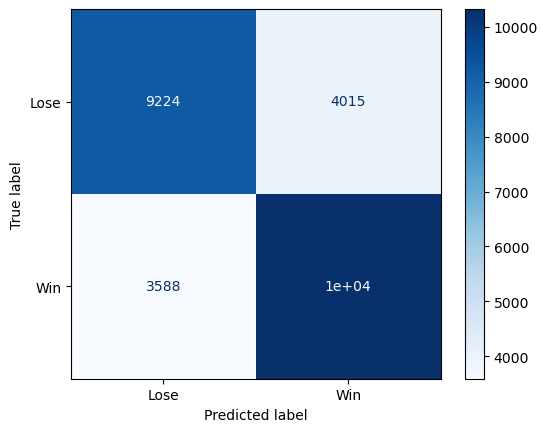

In [39]:
# Calculating the confusion matrix for the Random Forest tuned
cm_rf_tuned = confusion_matrix(y_test, y_pred_rf_tuned)

# Creating a ConfusionMatrixDisplay object 
display_cm_rf_tuned = ConfusionMatrixDisplay(confusion_matrix=cm_rf_tuned, display_labels=['Lose', 'Win'])

# Plotting the confusion matrix using ConfusionMatrixDisplay object
display_cm_rf_tuned.plot(cmap='Blues')

In [40]:
print(classification_report(y_test, y_pred_rf_tuned, digits= 2, target_names=['Lose', 'Win']))

              precision    recall  f1-score   support

        Lose       0.72      0.70      0.71     13239
         Win       0.72      0.74      0.73     13915

    accuracy                           0.72     27154
   macro avg       0.72      0.72      0.72     27154
weighted avg       0.72      0.72      0.72     27154



Our accuracy is right around 72%, which is slighly worse than our logistic regression model and about the same as our Gaussian Naive Bayes model. The random forest does a little more evenly than the other two models when it comes to predicting wins and losses. 

Now it's time to apply our trained model just to the tournament games in our years of interest. In the following section, we predict the outcomes for each tournamnet, check our accuracy score, and return the yearly accuracy ratings in a condensed dataframe called `rf_accuracy`

In [41]:
rf_pred_2018 = rf_tuned.predict(X_2018)
rf_pred_2019 = rf_tuned.predict(X_2019)
rf_pred_2021 = rf_tuned.predict(X_2021)
rf_pred_2022 = rf_tuned.predict(X_2022)
rf_pred_2023 = rf_tuned.predict(X_2023)

rf_accuracy_2018 = accuracy_score(y_2018, rf_pred_2018)
rf_accuracy_2019 = accuracy_score(y_2019, rf_pred_2019)
rf_accuracy_2021 = accuracy_score(y_2021, rf_pred_2021)
rf_accuracy_2022 = accuracy_score(y_2022, rf_pred_2022)
rf_accuracy_2023 = accuracy_score(y_2023, rf_pred_2023)

years=['2018','2019','2021','2022','2023']
rf_accuracy = pd.DataFrame([[rf_accuracy_2018,rf_accuracy_2019,rf_accuracy_2021,rf_accuracy_2022,rf_accuracy_2023]], columns=years)
rf_accuracy.index = ['rf_accuracy']
rf_accuracy

,2018,2019,2021,2022,2023
rf_accuracy,0.46269,0.43284,0.48485,0.47761,0.47761


The accuracy for this model is a little worse than the GNB for the first three years but does a little better in the 2022 and 2023 seasons. The accuracy is still pretty low though. 

Again, we generate the binary clssifier and probability prediction columns that we can add onto our original dataframe for interpretability later on if needed. 

In [42]:
rf_pred_prob_2018 = rf_tuned.predict_proba(X_2018)
rf_pred_prob_2018 = np.float64(rf_pred_prob_2018)
rf_pred_prob_2019 = rf_tuned.predict_proba(X_2019)
rf_pred_prob_2019 = np.float64(rf_pred_prob_2019)
rf_pred_prob_2021 = rf_tuned.predict_proba(X_2021)
rf_pred_prob_2021 = np.float64(rf_pred_prob_2021)
rf_pred_prob_2022 = rf_tuned.predict_proba(X_2022)
rf_pred_prob_2022 = np.float64(rf_pred_prob_2022)
rf_pred_prob_2023 = rf_tuned.predict_proba(X_2023)
rf_pred_prob_2023 = np.float64(rf_pred_prob_2023)

Following the same process as we did for the logistic regression, we use the following code to get the predicted probabilities for each year using the Random Forest model and will use that along with our accuracy data to generate our final `rf_matrix`.

In [43]:
rf_results = pd.concat([pd.DataFrame(rf_pred_prob_2018[:,1]), pd.DataFrame(rf_pred_prob_2019[:,1]), 
                        pd.DataFrame(rf_pred_prob_2021[:,1]), pd.DataFrame(rf_pred_prob_2022[:,1]), 
                        pd.DataFrame(rf_pred_prob_2023[:,1])], axis=1)

rf_results = rf_results.set_axis(['2018', '2019', '2021', '2022', '2023'], axis=1, inplace=False)

rf_results

,2018,2019,2021,2022,2023
0,0.46815,0.46815,0.46815,0.46805,0.46805
1,0.46334,0.46334,0.46815,0.47791,0.47791
2,0.46698,0.46698,0.46698,0.47791,0.47791
3,0.46815,0.46815,0.46698,0.46698,0.46698
4,0.46698,0.46698,0.46698,0.46805,0.46805
...,...,...,...,...,...
62,0.46698,0.46698,0.45373,0.46698,0.46698
63,0.46963,0.46963,0.46815,0.46698,0.46698
64,0.46963,0.46963,0.46698,0.46805,0.46805
65,0.47791,0.47791,0.46698,0.46698,0.46698


In [44]:
rf_results = rf_results.apply(lambda x: abs(x-.5))
rf_confidence = rf_results.sum().to_frame().T
rf_confidence.index = ['rf_confidence']

rf_matrix = pd.concat([rf_confidence,rf_accuracy],axis=0)
rf_matrix

,2018,2019,2021,2022,2023
rf_confidence,2.07375,2.07375,2.13100,2.09297,2.09297
rf_accuracy,0.46269,0.43284,0.48485,0.47761,0.47761


As a final step in our random forest model process, we want to take a look at which features were most important, and we get some very interesting results!  We went out of our way to include Road_Wins as a feature because we thought it might be important to success in a tournament atmosphere where there are no "home games," and it turns out that we were onto something.  Also of note, seed seems to carry a lot of weight, which translates to what we see in our brackets as the model predicts the 2023 outcomes in question 1. Other features like FG%, PPG, and Assists turned out to be meaningful as well.

Text(0, 0.5, 'Feature Names')

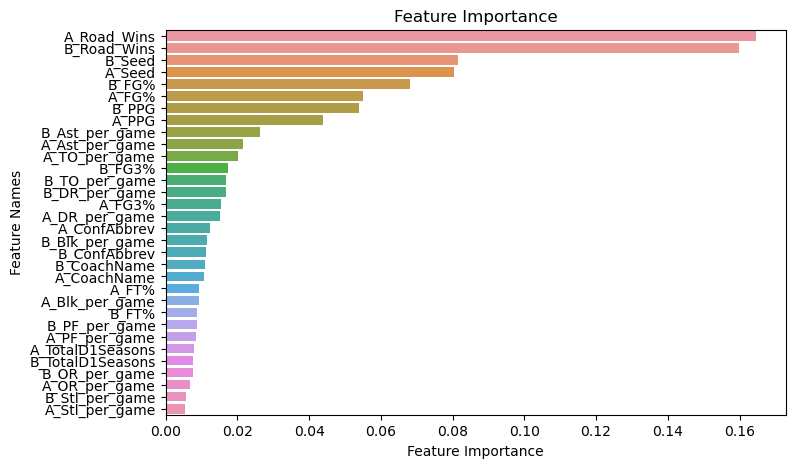

In [45]:
feature_names = X.columns
labels = ["Lose","Win"]

#getting feature importances
fimp = rf_tuned.feature_importances_

#putting them into dataframe
fimp = pd.DataFrame({'Features':feature_names,'Importance':np.array(rf_tuned.feature_importances_)})
fimp.sort_values(by=['Importance'], ascending=False,inplace=True)

#plotting feature importances (for the whole tree!)
plt.figure(figsize=(8,5))
sns.barplot(x='Importance', y='Features',data=fimp)

plt.title('Feature Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')

### Support Vector Machine Classifier

Our final model is a Support Vector Machine Classifier - here we start by initializing the model.

In [46]:
svm = SVC(random_state=seed)

# commented out to reduce compute time
svm.fit(X_train, y_train)

print("------ TRAIN ----------")
print(svm.score(X_train, y_train))
print("------ TEST ----------")
print(svm.score(X_test, y_test))

------ TRAIN ----------
0.7547169811320755
------ TEST ----------
0.7286219341533475


The support vector machine classifier starts out with a strong performance on both our training and testing data!  This is the best start we've seen since the initial 73.1% accuracy rating we got from the logistic regression.

Next, we'll generate a classification report to see if the model has a hard time predicting a particular class.

In [47]:
print(classification_report(y_test, svm.predict(X_test),target_names=["Lose","Win"]))

              precision    recall  f1-score   support

        Lose       0.73      0.71      0.72     13239
         Win       0.73      0.75      0.74     13915

    accuracy                           0.73     27154
   macro avg       0.73      0.73      0.73     27154
weighted avg       0.73      0.73      0.73     27154



The SVC is pretty balanced when it comes to predicting wins and losses, similar to our random forest performance. The next step is to tune the hyperparameters, and this particular step gave us a lot of trouble when training the model. When attempting to tune 2-3 values for 'gamma', 'C', and 'kernel', the GridSearchCV ran for a total of ~2400 minutes before we gave up and attempted to scale down the parameters. Even scaling down proved ineffective, as the tuning still took another 800 minute and one more 300 minute iteration without completing the search.

We settled on doing a bare-minimum hyperparameter tuning to meet the timeline of the project, and picked to decide between two values of gamma that were outside the default value of 1. By testing 0.1 and 10, we were able to test and see if a more complex decision boundary (which risks of overfitting), or a smoother decision boundary (which risks underfitting) does better for our data. If we had more time and were more aware of how computationally expensive tuning hyperparameters for the SVC is, we could've done more extensive tuning. 

As it turns out, the model test accuracy did worse than our initial model with default settings when it came to test accuracy, so we refrained from using the tested parameters from gamma and stuck with the default value of 1 instead.

In [48]:
svm = SVC(random_state=seed)
parameters = {'gamma': [0.1, 10]}
svm_tuned = GridSearchCV(svm, parameters, cv=5)
svm_tuned.fit(X_train, y_train)
print("------ Best Parameters  ----------")
print(svm_tuned.best_params_)
print("------ Best Model Train Accuracy ----------")
print(svm_tuned.score(X_train, y_train))
print("------ Best Model Test Accuracy ----------")
print(svm_tuned.score(X_test, y_test))

------ Best Parameters  ----------
{'gamma': 0.1}
------ Best Model Train Accuracy ----------
0.8447109659837223
------ Best Model Test Accuracy ----------
0.706709876997864


In [70]:
svc_tuned = SVC(random_state=seed, probability=True)
svc_tuned.fit(X_train, y_train)
y_pred_svc_tuned = svc_tuned.predict(X_test)
print("Accuracy:",svc_tuned.score(X_test, y_test))

Accuracy: 0.7286219341533475


Next, we'll generate a confusion matrix because we didn't do it in the previous step, but the classification report should stay the same, as we didn't use our tuned hyperparameters.

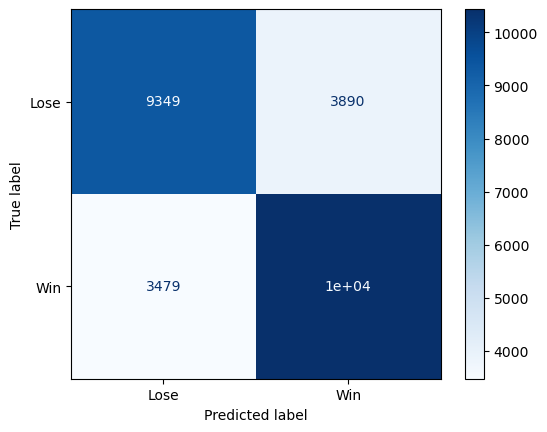

In [71]:
# Calculating the confusion matrix for the SVC tuned
cm_svc_tuned = confusion_matrix(y_test, y_pred_svc_tuned)

# Creating a ConfusionMatrixDisplay object 
display_cm_svc_tuned = ConfusionMatrixDisplay(confusion_matrix=cm_svc_tuned, display_labels=['Lose', 'Win'])

# Plotting the confusion matrix using ConfusionMatrixDisplay object
display_cm_svc_tuned.plot(cmap='Blues')

Now it's time to apply our trained model just to the tournament games in our years of interest. In the following section, we predict the outcomes for each tournamnet, check our accuracy score, and return the yearly accuracy ratings in a condensed dataframe called `svc_accuracy`

In [73]:
svc_pred_2018 = svc_tuned.predict(X_2018)
svc_pred_2019 = svc_tuned.predict(X_2019)
svc_pred_2021 = svc_tuned.predict(X_2021)
svc_pred_2022 = svc_tuned.predict(X_2022)
svc_pred_2023 = svc_tuned.predict(X_2023)

svc_accuracy_2018 = accuracy_score(y_2018, svc_pred_2018)
svc_accuracy_2019 = accuracy_score(y_2019, svc_pred_2019)
svc_accuracy_2021 = accuracy_score(y_2021, svc_pred_2021)
svc_accuracy_2022 = accuracy_score(y_2022, svc_pred_2022)
svc_accuracy_2023 = accuracy_score(y_2023, svc_pred_2023)

years=['2018','2019','2021','2022','2023']
svc_accuracy = pd.DataFrame([[svc_accuracy_2018,svc_accuracy_2019,svc_accuracy_2021,svc_accuracy_2022,svc_accuracy_2023]], columns=years)
svc_accuracy.index = ['svc_accuracy']
svc_accuracy

,2018,2019,2021,2022,2023
svc_accuracy,0.46269,0.43284,0.48485,0.47761,0.47761


The accuracy for this model is nearly identical to the random forest model and still lower than we would like to see.  

Again, we generate the binary clssifier and probability prediction columns that we can add onto our original dataframe for interpretability later on if needed. 

In [74]:
svc_pred_prob_2018 = svc_tuned.predict_proba(X_2018)
svc_pred_prob_2018 = np.float64(svc_pred_prob_2018)
svc_pred_prob_2019 = svc_tuned.predict_proba(X_2019)
svc_pred_prob_2019 = np.float64(svc_pred_prob_2019)
svc_pred_prob_2021 = svc_tuned.predict_proba(X_2021)
svc_pred_prob_2021 = np.float64(svc_pred_prob_2021)
svc_pred_prob_2022 = svc_tuned.predict_proba(X_2022)
svc_pred_prob_2022 = np.float64(svc_pred_prob_2022)
svc_pred_prob_2023 = svc_tuned.predict_proba(X_2023)
svc_pred_prob_2023 = np.float64(svc_pred_prob_2023)

An issue we ran into here was that when we went to predict the probabiliites to get confidence intervals, the SVC classifier did not offer any probabilities that deviated from .5, making it a poor fit for our question. Our confidence rating for this model will therefore be 0, or an indvalid/uninterpretable result.

In [75]:
svc_results = pd.concat([pd.DataFrame(svc_pred_prob_2018[:,1]), pd.DataFrame(svc_pred_prob_2019[:,1]), 
                        pd.DataFrame(svc_pred_prob_2021[:,1]), pd.DataFrame(svc_pred_prob_2022[:,1]), 
                        pd.DataFrame(svc_pred_prob_2023[:,1])], axis=1)

svc_results = svc_results.set_axis(['2018', '2019', '2021', '2022', '2023'], axis=1, inplace=False)

svc_results

,2018,2019,2021,2022,2023
0,0.50000,0.50000,0.50000,0.50000,0.50000
1,0.50000,0.50000,0.50000,0.50000,0.50000
2,0.50000,0.50000,0.50000,0.50000,0.50000
3,0.50000,0.50000,0.50000,0.50000,0.50000
4,0.50000,0.50000,0.50000,0.50000,0.50000
...,...,...,...,...,...
62,0.50000,0.50000,0.50000,0.50000,0.50000
63,0.50000,0.50000,0.50000,0.50000,0.50000
64,0.50000,0.50000,0.50000,0.50000,0.50000
65,0.50000,0.50000,0.50000,0.50000,0.50000


Generating the final `svc_matrix` as done with the previous models

In [76]:
svc_results = svc_results.apply(lambda x: abs(x-.5))
svc_confidence = svc_results.sum().to_frame().T
svc_confidence.index = ['svc_confidence']

svc_matrix = pd.concat([svc_confidence,svc_accuracy],axis=0)
svc_matrix

,2018,2019,2021,2022,2023
svc_confidence,0.00000,0.00000,0.00000,0.00000,0.00000
svc_accuracy,0.46269,0.43284,0.48485,0.47761,0.47761


We can concatenate all these model matricies together to get a `final_matrix` with all of our results.

In [77]:
final_matrix = pd.concat([lr_matrix,gnb_matrix,rf_matrix,svc_matrix], axis=0)
final_matrix

,2018,2019,2021,2022,2023
lr_confidence,29.15519,29.15519,29.11121,28.24326,28.24326
lr_accuracy,0.52239,0.49254,0.50000,0.49254,0.49254
gnb_confidence,33.50000,33.50000,33.00000,33.50000,33.50000
gnb_accuracy,0.46269,0.49254,0.53030,0.46269,0.46269
rf_confidence,2.07375,2.07375,2.13100,2.09297,2.09297
rf_accuracy,0.46269,0.43284,0.48485,0.47761,0.47761
svc_confidence,0.00000,0.00000,0.00000,0.00000,0.00000
svc_accuracy,0.46269,0.43284,0.48485,0.47761,0.47761


### Final Visualizations

We decided that these graphs worked better when accuracy rating and cumulative confidence were broken up into separate dataframes, so we do that here.

In [123]:
accuracy_matrix = pd.concat([lr_accuracy,gnb_accuracy,rf_accuracy,svc_accuracy], axis=0)
new_index = {'lr_accuracy': 'LR', 'gnb_accuracy': 'GNB', 'rf_accuracy': 'RF', 'svc_accuracy':'SVC'}
accuracy_matrix = accuracy_matrix.rename(index=new_index)
accuracy_matrix

,2018,2019,2021,2022,2023
LR,0.52239,0.49254,0.50000,0.49254,0.49254
GNB,0.46269,0.49254,0.53030,0.46269,0.46269
RF,0.46269,0.43284,0.48485,0.47761,0.47761
SVC,0.46269,0.43284,0.48485,0.47761,0.47761


In [125]:
confidence_matrix = pd.concat([lr_confidence,gnb_confidence,rf_confidence,svc_confidence], axis=0)
new_index = {'lr_confidence': 'LR', 'gnb_confidence': 'GNB', 'rf_confidence': 'RF', 'svc_confidence':'SVC'}
confidence_matrix = confidence_matrix.rename(index=new_index)
confidence_matrix

,2018,2019,2021,2022,2023
LR,29.15519,29.15519,29.11121,28.24326,28.24326
GNB,33.50000,33.50000,33.00000,33.50000,33.50000
RF,2.07375,2.07375,2.13100,2.09297,2.09297
SVC,0.00000,0.00000,0.00000,0.00000,0.00000


Now with our separate dataframes, we generate plots to compare how each of our models did across years.

<Figure size 3000x1500 with 0 Axes>

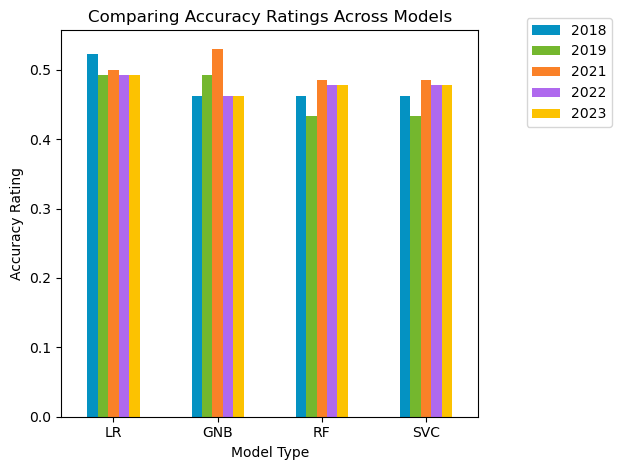

In [126]:
# Generate plot to compare accuracy ratings across models
plt.figure(figsize=(30,15))

# Generate a bar plot with one bar per model
accuracy_matrix.plot.bar(rot=0,color=['#0492c2', '#74b72e', '#fa8128', '#af69ee','#fcc201'])

# Set the x-label and y-label
plt.xlabel('Model Type')
plt.ylabel('Accuracy Rating')
plt.title('Comparing Accuracy Ratings Across Models')
plt.legend([2018,2019,2021,2022,2023],bbox_to_anchor=(1.1,1.05))

# Display the graph
plt.tight_layout()
plt.show()

<Figure size 3000x1500 with 0 Axes>

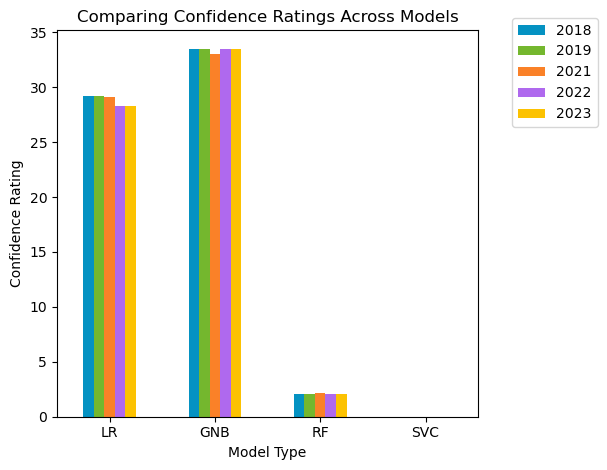

In [135]:
# Generate plot to compare cumulative confidence ratings across models
plt.figure(figsize=(30,15))

# Generate a bar plot with one bar per model
confidence_matrix.plot.bar(rot=0,color=['#0492c2', '#74b72e', '#fa8128', '#af69ee','#fcc201'])

# Set the x-label and y-label
plt.xlabel('Model Type')
plt.ylabel('Confidence Rating')
plt.title('Comparing Confidence Ratings Across Models')
plt.legend([2018,2019,2021,2022,2023],bbox_to_anchor=(1.3,1.05))

# Display the graph
plt.tight_layout()
plt.show()

### Conclusions
Although we were not able to find a model that was really successful at predicting game outcomes on a yearly basis, we were able to see that one performed slighly better than the others. Logistic Regression did a marginally better job at predicting tournament outcomes in most years (although GNB did very well at predicting the 2021 tournament relative to the other models). Our outcomes in terms of model performance and hyperparameters in this question are slightly different from those in question 1, but that is most likely because this question takes less data into account (ending at 2017 instead of 2022). 

From our most effective model (LR), we are able to see a slight decrease in overall cumulative confidence ratings across years. This does provide an answer to our question (that the predictions have gotten less certain over the past five years), although the scale is not dramatic at this point. 

#### Future Work
If exploring this question further, we would attempt to make the yearly dataframes cumulative across years instead of cutting off the data right at 2017 and using that dataframe for all subsequent yeras. Making that change would most likely have helped with our accuracy.

We would also go with a model other than SVC, which was computationally expensive to hypertune the parameters and did not end up giving us meaningful probability predictions.

### References

* https://towardsdatascience.com/a-beginners-guide-to-logistic-regression-in-python-470bdc57a33

* https://stackoverflow.com/questions/48947194/add-randomforestclassifier-predict-proba-results-to-original-dataframe

* https://medium.com/codex/do-i-need-to-tune-logistic-regression-hyperparameters-1cb2b81fca69

* https://towardsdatascience.com/tuning-the-hyperparameters-of-your-machine-learning-model-using-gridsearchcv-7fc2bb76ff27

* https://sparkbyexamples.com/pandas/pandas-remove-duplicate-columns-from-dataframe/

* https://www.kaggle.com/code/juanmah/tactic-03-hyperparameter-optimization-gnb

* Lab 6 Solution

* Lab 9 Solution

* https://scikit-learn.org/stable/modules/svm.html

* https://medium.com/grabngoinfo/support-vector-machine-svm-hyperparameter-tuning-in-python-a65586289bcb